# Product detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from kaggle_datasets import KaggleDatasets

from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

from tqdm import tqdm
%matplotlib inline

In [2]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU")
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU
Number of accelerators:  8


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
GCS_DS_PATH

'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590'

In [4]:
MINI_BATCH = 16 * strategy.num_replicas_in_sync
print("Training batch size = ", str(MINI_BATCH))

Training batch size =  128


In [5]:
train_df = pd.read_csv('../input/shopee-code-league-20/_DA_Product_Detection/train.csv')
test_df = pd.read_csv('../input/shopee-code-league-20/_DA_Product_Detection/test.csv')

In [6]:
train_df.shape, test_df.shape

((105392, 2), (12186, 2))

In [7]:
train_df.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [8]:
# Visualize training images
def show_train_image(category: str):
    #show sample 15 images from selected category
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
    train_path = '../input/shopee-code-league-20/_DA_Product_Detection/train/train'
    sample_img = pd.Series(os.listdir(os.path.join(train_path, category))).sample(15).values
    
    for idx, images in tqdm(enumerate(sample_img)):
        img_path = os.path.join(train_path, category, images)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

15it [00:00, 32.23it/s]


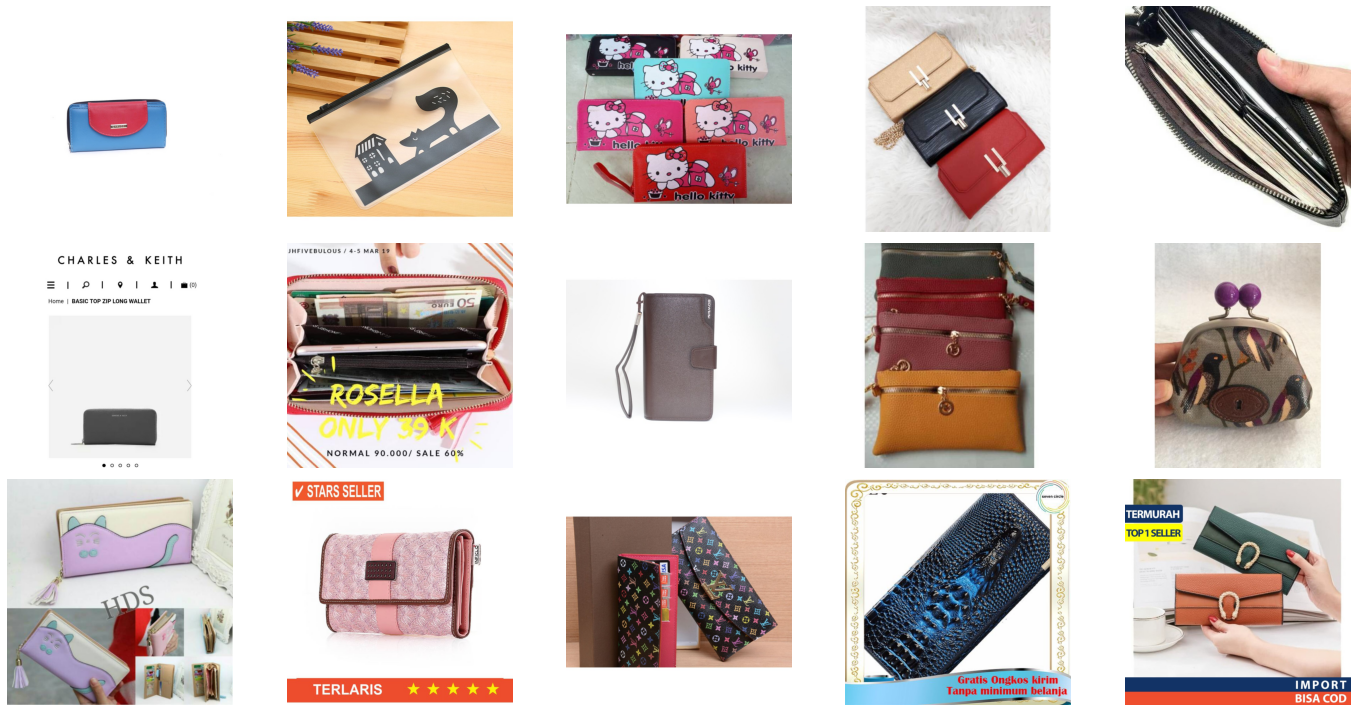

In [9]:
show_train_image('08')

In [10]:
# Visualize test images
def show_test_image():
    #show sample 10 images from test set
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24,10))
    test_path = '../input/shopee-code-league-20/_DA_Product_Detection/test/test'
    sample_img = pd.Series(os.listdir(test_path)).sample(10).values
    
    for idx, images in tqdm(enumerate(sample_img)):
        img_path = os.path.join(test_path, images)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

10it [00:00, 32.70it/s]


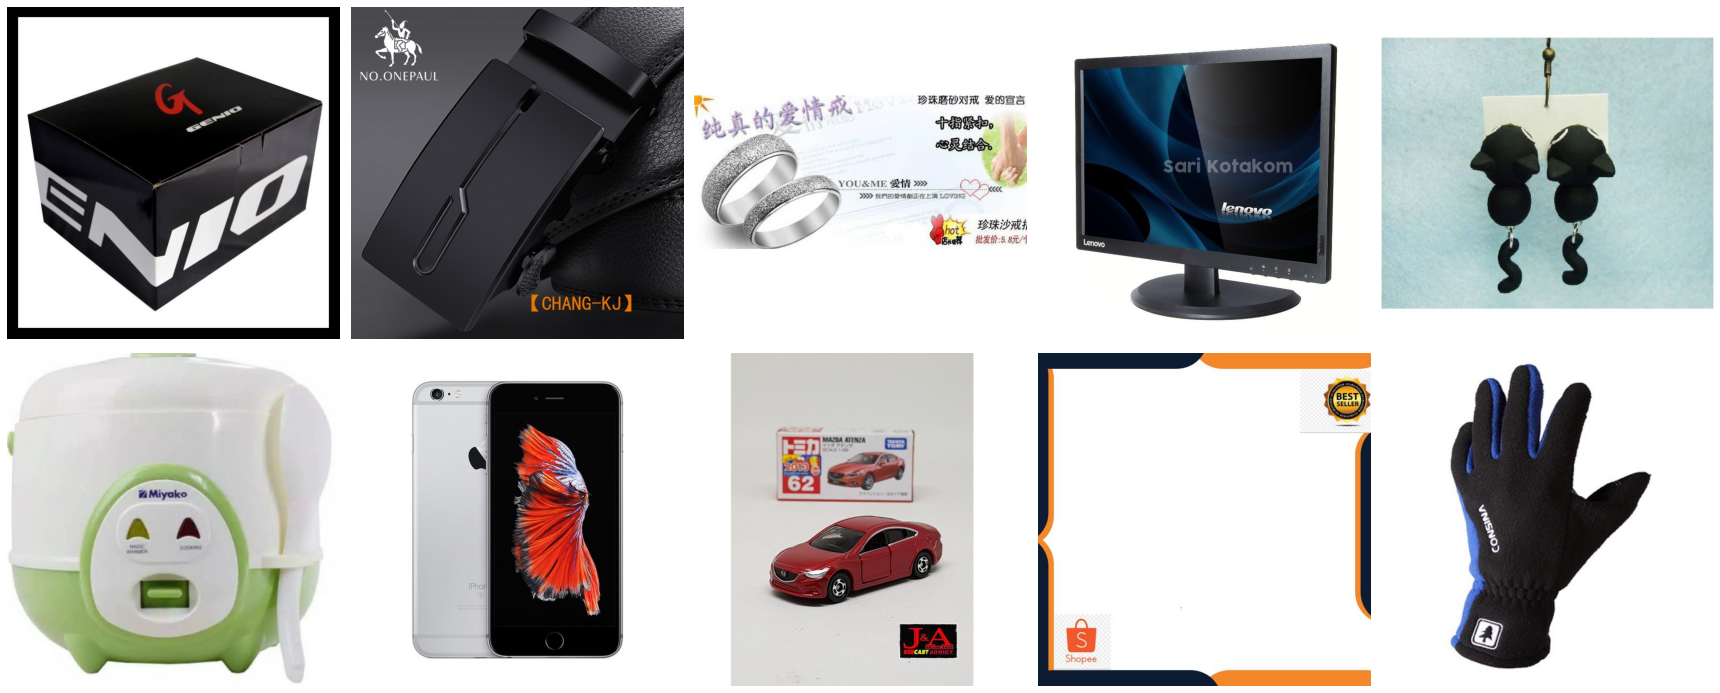

In [11]:
show_test_image()

In [12]:
# Visualize datasets quantity for each category
per_cat = train_df.groupby(['category'], as_index=False).count()
per_cat

,category,filename
0,0,2683
1,1,2702
2,2,2687
3,3,2703
4,4,2703
5,5,2641
6,6,2641
7,7,2660
8,8,2700
9,9,2698


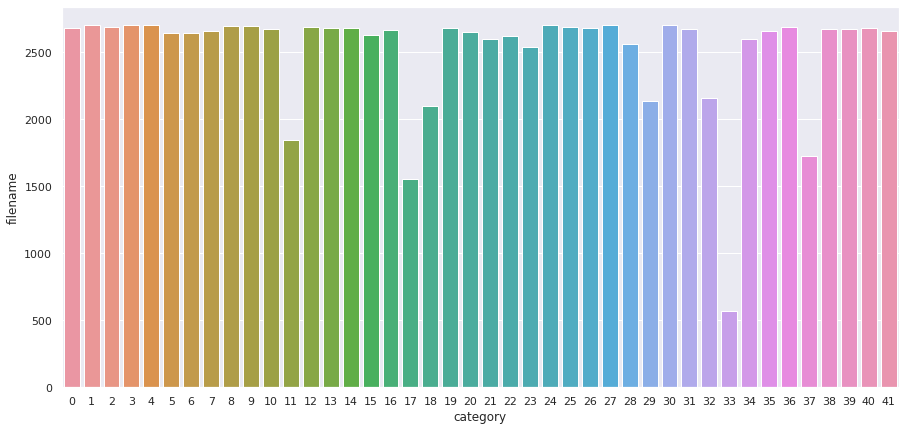

In [13]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,7))
ax = sns.barplot(x="category", y="filename", data=per_cat)

### Nooo!! we're confronted with imbalance dataset
What should i do?
- Oversampling
- Undersampling
- etc.

#### First try strategy : Doing nothing and monitering its score


### Create data paths

In [14]:
categories = np.sort(train_df['category'].unique())
categories

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

In [15]:
# Sample 1500 data per each categories

dataset_path = {}
Check_res_path = {}
for cat in categories:
    Check_res_path[cat] = train_df[train_df['category'] == cat]['filename']
    try:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(1500)
    except:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1)

In [16]:
## Class 33
dataset_path[33] =  train_df[train_df['category'] == 33]['filename'].sample(frac=2.5, replace = True, random_state=101)
dataset_path[33]

13343    99b2c97705ad0f758ae2e86c7fc6499b.jpg
13157    ac254d72408fde3695c0281492cbfbef.jpg
12895    c658f1f1f53bb8625e5fa4409ea9eed9.jpg
13213    b282c7449f649662ec3ce0046bc85991.jpg
13372    1e5ece8768af94e90b994b73082390cf.jpg
                         ...                 
12826    93651fa0d5ff0df277bd22e85c4f3872.jpg
13357    a3c487c57d6b567cfb46a0a118dbe29a.jpg
13057    4cd2c66410fdda2090abee922ca94c0b.jpg
13096    4394e4bc7dd5b1e00c34cf61fbcc1c11.jpg
12883    17b80f18308a5de70a2437756904eefe.jpg
Name: filename, Length: 1432, dtype: object

In [17]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

In [18]:
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH,'_DA_Product_Detection', 'train', 'train', category_list[idx], path))

In [19]:
train_paths[:30000:3000]

['gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/00/3cbfc9cac205f5d1bb2ba9a692b0eb10.jpg',
 'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/02/abe3683ea3868d839a00a76d3e7a0b38.jpg',
 'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/04/5aa9a71cc60dd69e7d5c721da1ddee26.jpg',
 'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/06/00dd15a66badc578aee293931987d6ef.jpg',
 'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/08/0c2347dc571e389a76abf15a886b2480.jpg',
 'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/10/3dbb4ab243c3fbf54a94c6330af39a89.jpg',
 'gs://kds-954291d76a6328757b40f78f52832089eea5ded948c9ff32143d9590/_DA_Product_Detection/train/train/12/51befb6e05b20d3637cda61b304a833

In [20]:
labels = []
for i in range(len(train_paths)):
    label = train_paths[i].split(os.path.sep)[-2]
    labels.append(int(label))

In [21]:
print(len(train_paths))
print(len(labels))

62932
62932


In [22]:
#Check labels with train_paths
print(labels[:30000:3000])
ch = []
for path in train_paths[:30000:3000]:
    lb_extract = path.split(os.path.sep)[-2]
    ch.append(int(lb_extract))
print(ch)
if labels[:30000:3000] == ch:
    print('Match!!')
else : print('Try again')

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Match!!


In [23]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
train_labels = to_categorical(labels)

In [24]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,'_DA_Product_Detection', 'test', 'test', path))
    
test_paths = np.array(test_paths)

## Images resolution overviews

In [ ]:
check_list = []

for idx, key in enumerate(Check_res_path.keys()):
    if key == idx:
        for path in Check_res_path[idx]:
            check_list.append(os.path.join('../input/shopee-code-league-20/_DA_Product_Detection/train/train', category_list[idx], path))

In [ ]:
from PIL import Image

sizes = [Image.open(f, 'r').size for f in tqdm(check_list)]

In [ ]:
sizes_df = pd.DataFrame(data = sizes, columns = ['H', 'W'])

In [ ]:
def make_range(data):
    if data < 100:
        return '0-100'
    elif 100 < data < 200:
        return '100-200'
    elif 100 < data < 200:
        return '100-200'
    elif 200 < data < 300:
        return '200-300'
    elif 300 < data < 400:
        return '300-400'
    elif 400 < data < 500:
        return '400-500'
    elif 500 < data < 550:
        return '500-550'
    elif 550 < data < 600:
        return '550-600'
    elif data > 600:
        return '600+'

In [ ]:
sizes_df['range'] = sizes_df['H'].apply(lambda df : make_range(df))

In [ ]:
res_range = sizes_df.groupby(['range']).count()
res_range

In [ ]:
_550_percentage = (sum(res_range['H'][-2:])/sum(res_range['H']))*100
_500_percentage = (sum(res_range['H'][4:])/sum(res_range['H']))*100
print('The percentage of images that have more than 550 pixels is ', str(_550_percentage) ,'%')
print('The percentage of images that have more than 500 pixels is ', str(_500_percentage) ,'%')

##### Since most 90% of images have at least 550 pixel resolution, So i decided to using EfficientNetB7 as a transfer neuralnet which has 600 pixels base resolution 

### Create validation set using sklearn split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, shuffle=True, stratify=train_labels, test_size=0.1, random_state=101)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((56638,), (6294,), (56638, 42), (6294, 42))

### Decoding image

In [26]:
# For training set label = True and return with decoded_image and label
# For test set label = False and return only decoded_image
def decode_image(filename, label=None, image_size=(600, 600)):
    file = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(file, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 #From 0-255 to 0-1
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [27]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.25)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     image = tf.image.random_hue(image, max_delta=0.2)
    
    if label is None:
        return image
    else:
        return image, label

#### Create input pipelines
- using tf.data

In [28]:
training_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .map(decode_image, num_parallel_calls=AUTOTUNE)
    .map(data_augment, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(MINI_BATCH)
    .prefetch(AUTOTUNE)
)

validate_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .map(decode_image, num_parallel_calls=AUTOTUNE)
    .batch(MINI_BATCH)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTOTUNE)
    .batch(MINI_BATCH)
)

In [29]:
training_dataset

<PrefetchDataset shapes: ((None, 600, 600, 3), (None, 42)), types: (tf.float32, tf.float32)>

In [ ]:
# Batch data overview
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
#print("Training data label examples:", label.numpy()[0])
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)

## Transfer learning EfficientNetB7

In [30]:
# Shape selection
B0_SHAPE = (224, 224, 3)
B1_SHAPE = (240, 240, 3)
B2_SHAPE = (260, 260, 3)
B3_SHAPE = (300, 300, 3)
B4_SHAPE = (380, 380, 3)
B5_SHAPE = (456, 456, 3)
B6_SHAPE = (528, 528, 3)
B7_SHAPE = (600, 600, 3)

In [32]:
!pip install -q efficientnet
from tensorflow.keras.layers import Dense, Lambda, Input
from tensorflow.keras.models import Model
import efficientnet.tfkeras as effnet

**BaseLine model efficientNetB7**

In [33]:
"""with strategy.scope():
     model = tf.keras.Sequential([
         EfficientNetB7(weights='imagenet', # imagenet
                        include_top=False,
                        pooling='max'), # max
         Dense(1024, activation='swish'),
         Dense(42, activation='softmax')
     ])
    
     model.layers[0].trainable = False
    
     model.compile(optimizer = 'adam',
                   loss = 'categorical_crossentropy', # num classes
                   metrics=['accuracy'])
    
     model.summary()"""

"with strategy.scope():\n     model = tf.keras.Sequential([\n         EfficientNetB7(weights='imagenet', # imagenet\n                        include_top=False,\n                        pooling='max'), # max\n         Dense(1024, activation='swish'),\n         Dense(42, activation='softmax')\n     ])\n    \n     model.layers[0].trainable = False\n    \n     model.compile(optimizer = 'adam',\n                   loss = 'categorical_crossentropy', # num classes\n                   metrics=['accuracy'])\n    \n     model.summary()"

### Detect Fine Grain Details: Bilinear CNN  

<div>
<img src="https://miro.medium.com/max/820/1*Y-629BmgDNFpLumnklJyaA.png" width="800"/>
</div>

ref : https://scorrea92.medium.com/bilinear-cnn-models-in-tensorflow-keras-801121cc8c4d

Bilinear simply the product of two network function



In [34]:
# Bilinear EfficientNet 
# ref: BiLinear EfficientNet Focal Loss+ Label Smoothing 
#      https://www.kaggle.com/jimitshah777/bilinear-efficientnet-focal-loss-label-smoothing ---> Plant Pathology 2020 notebook

import tensorflow as tf

def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1) # v2 -> change dim to axis
    return z_l2

In [35]:
# Bilinear EfficientNet 
# ref: BiLinear EfficientNet Focal Loss+ Label Smoothing 
#      https://www.kaggle.com/jimitshah777/bilinear-efficientnet-focal-loss-label-smoothing ---> Plant Pathology 2020 notebook

# load the model
def load_model():
    input_tensor = tf.keras.Input(shape=B7_SHAPE)
    
    model1 = effnet.EfficientNetB7(weights='imagenet', include_top = False, input_tensor=input_tensor, input_shape=B7_SHAPE)
    model2 = effnet.EfficientNetB7(weights='noisy-student', include_top = False, input_tensor=input_tensor, input_shape=B7_SHAPE)
    
    for i, layer in enumerate(model1.layers):
        layer._name = 'model1_' + layer.name

    last_layer1 = model1.get_layer('model1_top_conv')
    last_output1 = last_layer1.output

    for i, layer in enumerate(model2.layers):
        layer._name = 'model2_' + layer.name
        
    last_layer2 = model2.get_layer('model2_top_conv')
    last_output2 = last_layer2.output
    
    model1_ = Model(inputs=model1.input, outputs=last_output1)
    model2_ = Model(inputs=model2.input, outputs=last_output2)
    
    model1_.trainable = False
    model2_.trainable = False
    
    model1_.compile(optimizer='adam',loss = 'categorical_crossentropy')
    model2_.compile(optimizer='adam',loss = 'categorical_crossentropy')
    
    d1=model1_.output
    d2=model2_.output

    bilinear = Lambda(outer_product, name='outer_product1')([d1,d2])
    
    predictions=Dense(42, activation='softmax', name='predictions')(bilinear)
    model = Model(inputs=model1.input, outputs=predictions)

    return model

In [36]:
with strategy.scope():
    
    model = load_model()

    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy', # num classes
                  metrics=['categorical_accuracy'])

258072576/258068648 [==============================] - 3s 0us/step


In [37]:
import math

LR = 0.0005
EPOCHS = 16
WARMUP = 4

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR, num_warmup_steps=WARMUP, num_training_steps=EPOCHS)

In [38]:
n_steps = y_train.shape[0] // MINI_BATCH

history = model.fit(
    training_dataset, 
    steps_per_epoch=n_steps, # Infinite dataset due to repeat function
    validation_data=validate_dataset,
    epochs=EPOCHS,
    callbacks = [lr_schedule]
)

Epoch 1/16

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
442/442 [==============================] - 2782s 6s/step - loss: 3.7376 - categorical_accuracy: 0.0229 - val_loss: 3.7376 - val_categorical_accuracy: 0.0237
Epoch 2/16

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000125.
442/442 [==============================] - 484s 1s/step - loss: 3.0420 - categorical_accuracy: 0.3888 - val_loss: 1.6046 - val_categorical_accuracy: 0.6829
Epoch 3/16

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
442/442 [==============================] - 486s 1s/step - loss: 1.7911 - categorical_accuracy: 0.6277 - val_loss: 1.1698 - val_categorical_accuracy: 0.7251
Epoch 4/16

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000375.
442/442 [==============================] - 486s 1s/step - loss: 1.3940 - categorical_accuracy: 0.6836 - val_loss: 1.0348 - val_categorical_accuracy: 0.7496
Epoch 5/16

Epoch 00005: LearningRateScheduler re

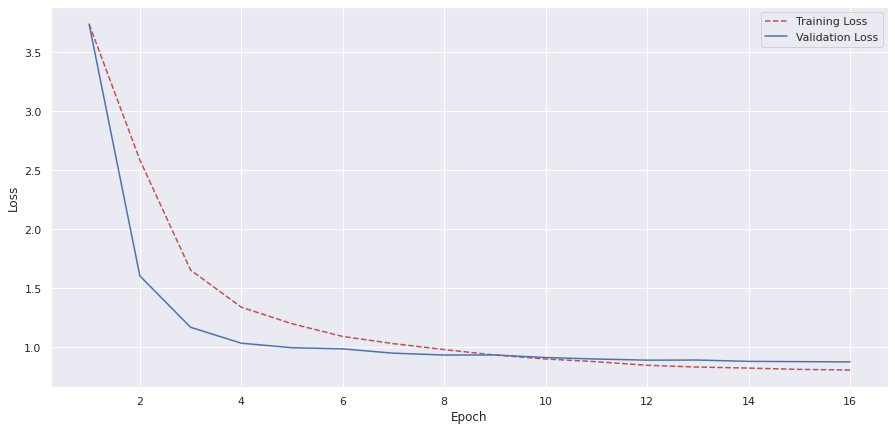

In [43]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
plt.figure(figsize=(15,7))
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [44]:
prediction = model.predict(test_dataset, verbose=1)

96/96 [==============================] - 519s 5s/step


In [52]:
# Test prediction data
print(prediction[0])
print("----------------------------")
print("This test data belong to class : ", str(prediction[0].argmax(axis=0)))

[5.12521947e-04 4.95863322e-04 7.11208559e-04 2.01520612e-04
 7.43996236e-04 5.64391157e-05 9.37365839e-05 2.14800137e-04
 2.59827299e-04 5.00428083e-04 1.12024434e-04 6.48129033e-04
 3.11013847e-03 1.20872392e-04 2.80838314e-04 5.39454108e-04
 2.04584212e-04 4.30407003e-04 6.52606424e-04 1.61456934e-04
 6.39434218e-01 1.83860306e-04 1.18712283e-04 7.82402130e-05
 1.72285785e-04 3.41026258e-04 1.30879402e-04 9.17558675e-04
 1.79557348e-04 7.18350930e-04 5.32902661e-04 2.29161087e-04
 7.29761086e-05 4.33606838e-05 7.37952578e-05 1.56844224e-04
 8.91108415e-04 8.28070915e-04 5.12081897e-04 1.27624935e-02
 2.56588246e-04 3.31315041e-01]
----------------------------
This test data belong to class :  20


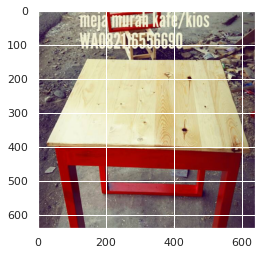

In [63]:
img_path = '../input/shopee-code-league-20/_DA_Product_Detection/test/test/fd663cf2b6e1d7b02938c6aaae0a32d2.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

15it [00:00, 28.67it/s]


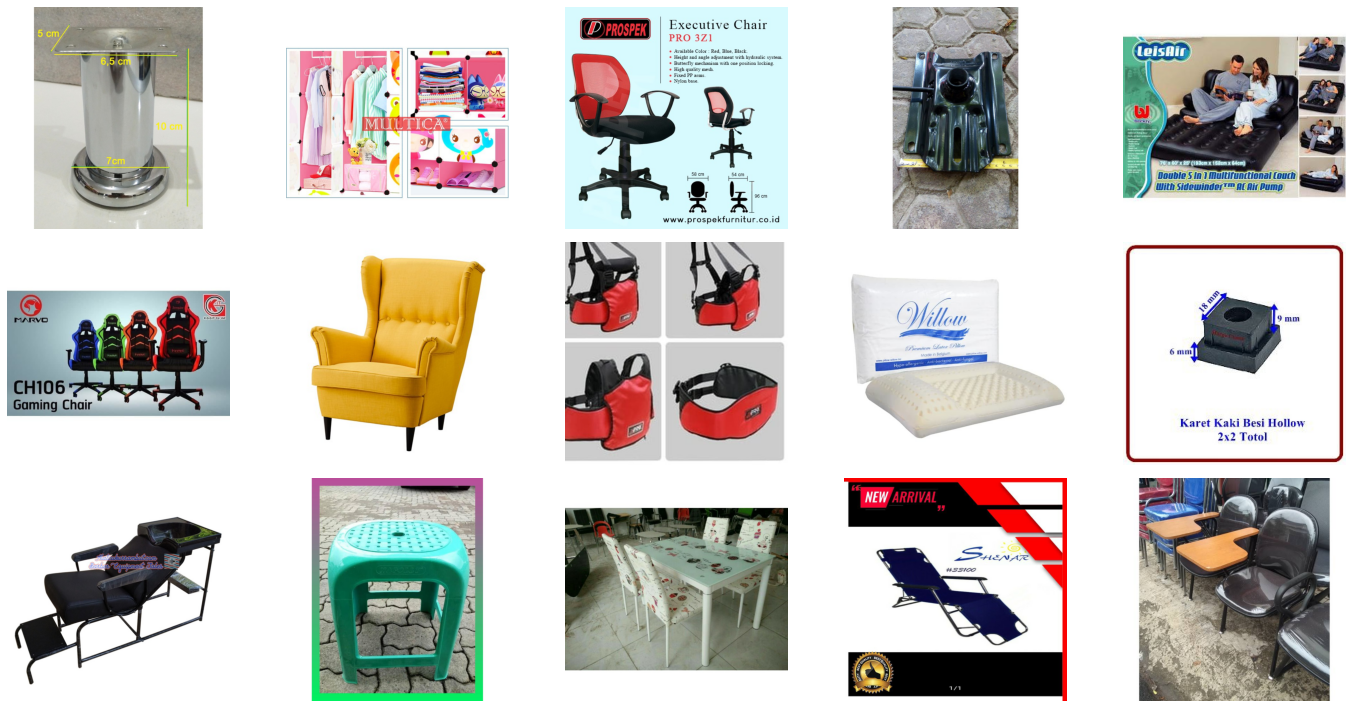

In [65]:
# Example image in category 20
show_train_image('20')

In [64]:
# drop existing feature
test_df = test_df.drop('category', axis=1)

# change with prediction
test_df['category'] = prediction.argmax(axis=1)

# then add zero-padding (1->01, 8->08)
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [66]:
test_df

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12
...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,16
12182,efbe41a1c2b666b70e337e438559808b.jpg,19
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,34
12184,ac3d136124617637a05ba66694e381ef.jpg,15


In [70]:
test_df = test_df.sort_values('filename').reset_index(drop=True)
test_df

,filename,category
0,0004b03ad7eabfb3989727c461310a84.jpg,12
1,0004d34271d0a0253f8a95d0746bae05.jpg,16
2,000d4ad3d0a372fd6eea2fee6bf738ef.jpg,40
3,0012f125ad07123e69468ae1d1d59de4.jpg,22
4,0015831b249b856e569e883a9dc6d4fa.jpg,12
...,...,...
12181,ffef3b0e7505855ba5794ebab9aff719.jpg,09
12182,ffef86f7872cd020992e00b7cf6585c7.jpg,20
12183,fff8fdfc178e3e94414fc10c69271f88.jpg,10
12184,fff9ee1d7f920b920dd603631d24bc07.jpg,23


In [71]:
test_df.to_csv('submission.csv', index=False)